In [3]:
import os
import numpy as np
import pandas as pd
os.chdir("/content/drive/MyDrive/cs289/proj/code")

In [6]:
pip install pysolnp

     |████████████████████████████████| 914 kB 13.3 MB/s 


In [ ]:
from data_process import data_prep_task
from learners import *
from sl_task import sl_task
from screeners import Screen_univar, Screen_l1
from pipeline import Pipeline
from sl_vim import importance

In [ ]:
"""
 import clean cloud data
"""
X_t, X_v, Y_t, Y_v = data_prep_task('cloud', test_size=0.3)

# X_t = (X_t - X_t.mean())/(X_t.std())
# X_v = (X_v - X_v.mean())/(X_v.std())
Y_t[np.where(Y_t == -1)] = 0
Y_v[np.where(Y_v == -1)] = 0

In [9]:
"""
 fit sl
"""
# Step 1. define task
task = sl_task(X = X_t, Y = Y_t, family = "Binomial", K = 10)

# Step 2. define candidate learners
L_glm = Lrnr_glm(sl_task = task)
L_rf = Lrnr_rf(sl_task = task)
L_xgb = Lrnr_xgboost(sl_task = task, num_round = 200)


stack = [L_glm, L_rf, L_xgb]

# Step 3. initialize sl
sl = initialize_sl(sl_task = task, stack = stack, meta = "solnp")


In [10]:
sl.train()

Training on Fold 1 of 10 

Training on Fold 2 of 10 

Training on Fold 3 of 10 

Training on Fold 4 of 10 

Training on Fold 5 of 10 

Training on Fold 6 of 10 

Training on Fold 7 of 10 

Training on Fold 8 of 10 

Training on Fold 9 of 10 

Training on Fold 10 of 10 



In [11]:
# summary sl
sl.summary()

 Num. of cv folds:  10 
 Meta learner:  solnp 
 n:  57503 
 p:  8
  learner        weight   cv_risk
0     glm  4.353578e-09  0.162684
1      rf  7.002742e-09  0.114991
2     xgb  1.000000e+00  0.035121


In [12]:
# calculate validation risk with sl
y_hat = sl.predict(X_v)
binomial_loglik_loss(y_hat, Y_v)

0.03293723251305453

In [13]:
for lr in sl.stack:
  y_hat = lr.predict(X_v)
  print(lr.name)
  print(binomial_loglik_loss(y_hat, Y_v))

glm
0.16665565240261915
rf
0.11382043879463341
xgb
0.032937230604167


In [14]:
# roc curve 
from sklearn import metrics
import matplotlib.pyplot as plt 

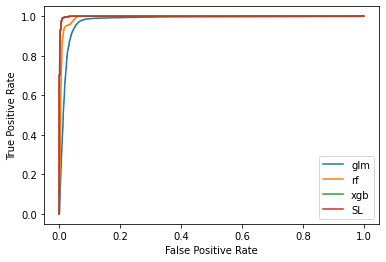

In [15]:
# plot individual learner roc curve
for lrnr in sl.stack:
  y_hat = lrnr.predict(X_v)
  fpr, tpr, _ = metrics.roc_curve(Y_v,  y_hat)
  plt.plot(fpr,tpr, label = lrnr.name)

# plot sl roc curve
y_hat = sl.predict(X_v)
fpr, tpr, _ = metrics.roc_curve(Y_v,  y_hat)
plt.plot(fpr,tpr, label = "SL")

# dec
plt.legend()
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.savefig("roc_cloud.pdf")

In [16]:
import seaborn as sns

In [17]:
df = pd.read_csv('data/cloud_data/image3.txt', delim_whitespace=True, header=None,
                 names=['y', 'x', 'expert label','NDAI', 'SD', 'CORR', 'DF', 'CF', 'BF', 'AF', 'AN'])

In [18]:
X_new = df[df.columns.difference(['y', 'x', 'expert label'])].to_numpy()

preds = sl.predict(X_new)
preds[preds > 0.5] = 1
preds[preds <= 0.5] = -1
preds[df['expert label'] == 0.0 ] = 0

In [147]:
# np.sum(np.absolute(df['expert label'].astype(int) - preds))/len(preds)

0.013222135348796803

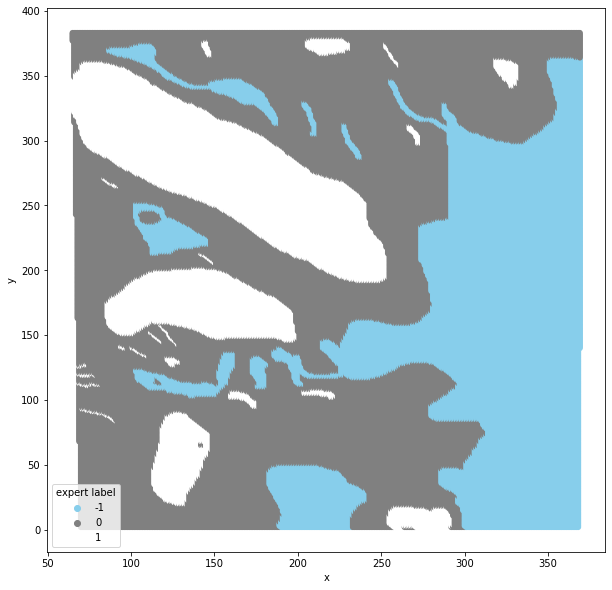

In [19]:
# color palette as dictionary
palette = {1:"white",
           -1:"skyblue", 
           0:"grey"}

plt.figure(figsize=(10,10))
sns.scatterplot(x=df['x'], y=df['y'], hue=df['expert label'].astype(int), palette=palette, linewidth=0)
# plt.savefig("p_cloud3_true.pdf")

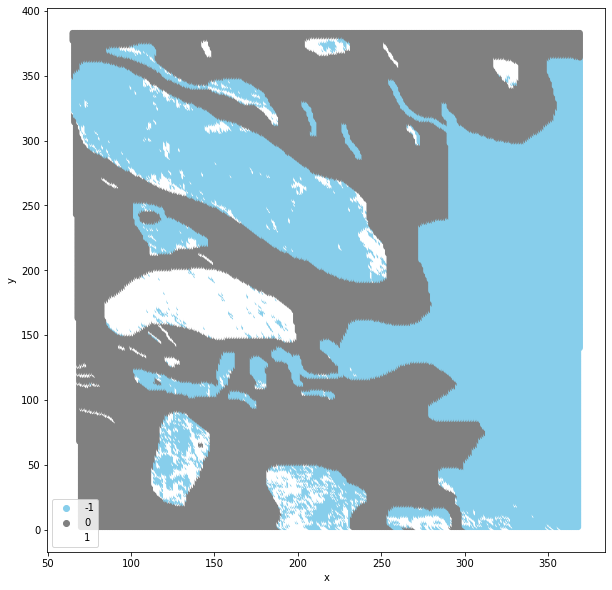

In [20]:
# color palette as dictionary
palette = {1:"white",
           -1:"skyblue", 
           0:"grey"}

plt.figure(figsize=(10,10))
sns.scatterplot(x=df['x'], y=df['y'], hue=preds.astype(int), palette=palette, linewidth=0)
# plt.savefig("p_cloud3_pred.pdf")